In [1]:
import os
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
kegg_labels = pd.read_csv('kegg_labels.csv', index_col = 0)
def translate_kegg(X):
    res = []
    for x in X:
        try:
            res.append(kegg_labels.loc[x].values[0])
        except:
            res.append(x)
    return res

In [3]:
# load SBML model and get parameter labels
modelfile = os.getcwd()+'/models/240621_VN_Metabolism_Gly.sbml' # filled nan values with mean for now
r_prefit = te.loadSBMLModel(modelfile)
model_rxns = pd.read_csv(os.getcwd()+'/src/frenda_brenda/Files/Reduced Complexity/Reaction_VN_Metabolism_Gly.csv')


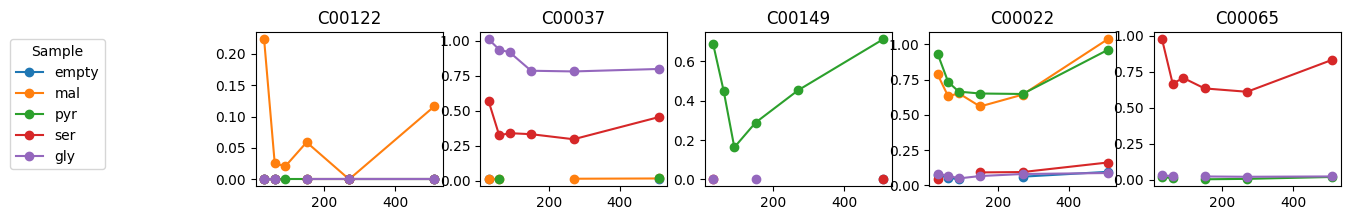

In [4]:
# get data and metadata for experiment
with open('data/230623_Kinetics_DA/simulation_ready.pkl', 'rb') as f:
    simulation_ready = pickle.load(f)
    init_concentrations_230623 = {k:v/1000 for k,v in simulation_ready['init_concentrations'].items()}   
    metadata_230623 = simulation_ready['metadata']
    measurements_230623 = simulation_ready['measurements']


labels = {'Mdh':'EC11137','Pyc':'EC6411', 'Fdh':'EC11719','EC117984':'EC11719','':'C00058','C00158_hct':'C00158HCT'}
init_concentrations_230623 = {k0:{k: 0 if ('EC' in k and np.isnan(v)) else v for k,v in v0.items()} for k0, v0 in init_concentrations_230623.items()}

# preprocessing

metadata_230623['measurement_labels'] = metadata_230623['measurement_labels'][1:]
measurements_230623 = {k:v[:,1:] for k,v in measurements_230623.items()}

measurements_230623['mal'][:,2] = np.full(len(metadata_230623['timepoints']['mal']),np.nan)
measurements_230623['pyr'][:,3] = measurements_230623['pyr'][:,3]/4

# thinking zeros may be driving the error up  
for k,v in measurements_230623.items():
    v[v < 10E-4] = 10E-5
    measurements_230623[k] = v


fudge_factors_230623 = {k:v for k,v in zip(metadata_230623['measurement_labels'],[1,0.1,2.2,1,1])} # to mM in figure
plt.figure(figsize=(14,2))
for s in metadata_230623['sample_labels']:
    metadata_230623['timepoints'][s] = metadata_230623['timepoints'][s] + 30*60
    for i,m in enumerate(metadata_230623['measurement_labels']):
        measurements_230623[s][:,i] = measurements_230623[s][:,i]*fudge_factors_230623[m]
        plt.subplot(1,len(metadata_230623['measurement_labels']),i+1)
        plt.plot(metadata_230623['timepoints'][s]/60, measurements_230623[s][:,i],'-o')
        plt.title(m)
plt.legend(metadata_230623['sample_labels'],bbox_to_anchor=(-6.15, 1), loc='upper left', title='Sample')

# define variables that don't change during fitting, but could be different across samples
# (dilution factor, biosynthesis metabolites, which enzymes are present)
variables_230623 = {}
for s in metadata_230623['sample_labels']:
    variables_230623[s] = {'dilution_factor':1/metadata_230623['dilution_factor'][s]}
    variables_230623[s] = {**variables_230623[s] , **{p:1 for p in r_prefit.getGlobalParameterIds() if 'p_EC' in p}}
    variables_230623[s] = {**variables_230623[s] , **init_concentrations_230623[s]}

In [5]:
# get all the parameters that can vary during the fitting
kcat_labels = [p for p in r_prefit.getGlobalParameterIds() if 'Kcat' in p]
km_labels = [p for p in r_prefit.getGlobalParameterIds() if 'Km' in p]
ki_labels = [p for p in r_prefit.getGlobalParameterIds() if 'Ki' in p]
Gnc_labels = [p for p in r_prefit.getGlobalParameterIds() if 'Gnc' in p ]
Gc_labels = [p for p in r_prefit.getGlobalParameterIds() if 'Gc' in p ]

sbml = r_prefit.getSBML()
metabolites = [s for s in r_prefit.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [v for v in [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+150:sbml.find('<initialAssignment symbol="'+s+'">')+150+len(s)]).split(' ')[0] for s in metabolites] if 'v' in v]

parameter_labels = kcat_labels + km_labels + ki_labels + Gnc_labels + Gc_labels + metabolites_labels
parameter_labels.append('rel0') # what are good bounds for this?
# last parameter is reserved for heterelogous enzyme multiplier

# make upper and lower bounds
upper = np.array([r_prefit[i]*100 for i in kcat_labels] + 
                 [r_prefit[i]*100 for i in km_labels] + 
                 [r_prefit[i]*100 for i in ki_labels] +
                 [1 for _ in Gnc_labels] +
                 [1 for _ in Gc_labels] +
                 [100 for _ in metabolites_labels] + 
                 [100])

lower = np.array([r_prefit[i]/100 for i in kcat_labels] + 
                 [r_prefit[i]/100 for i in km_labels] + 
                 [r_prefit[i]/100 for i in ki_labels] +
                 [1/100 for _ in Gnc_labels] +
                 [1/100 for _ in Gc_labels] +
                 [1/100 for _ in metabolites_labels] + 
                 [1/100])

p_initial = np.array([r_prefit[i] for i in kcat_labels] + 
                     [r_prefit[i] for i in km_labels] + 
                     [r_prefit[i] for i in ki_labels] +
                     [0.9 for _ in Gnc_labels] +
                     [0.9 for _ in Gc_labels] +
                     [1 for _ in metabolites_labels] + 
                     [1])

widths = np.array([10 for _ in kcat_labels] + 
                  [10 for _ in km_labels] + 
                  [10 for _ in ki_labels] +
                  [1.1 for _ in Gnc_labels] +
                  [1.1 for _ in Gc_labels] +
                  [10 for _ in metabolites_labels] + 
                  [10])

In [6]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = [measurements_230623], 
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=[metadata_230623],
    variables=[variables_230623],
    scale=True)

with open('results/240621_VNMetGly_AllData/train_myprob.obj', 'wb') as file:
    pickle.dump(myprob, file)

import pickle
with open('results/240621_VNMetGly_AllData/checkpoint_t.dat', 'rb') as file:
    pops = pickle.load(file)
top_pop = pg.population(pg.problem(myprob), size = 0)
list(map(top_pop.push_back, pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:10],:],pops[0].get_f()[np.argsort(pops[0].get_f()[:,0])[:10],:]));

In [7]:
with open('results/240621_VNMetGly_AllData/logs_t.dat', 'rb') as file:
    logs, test_fit = pickle.load(file)

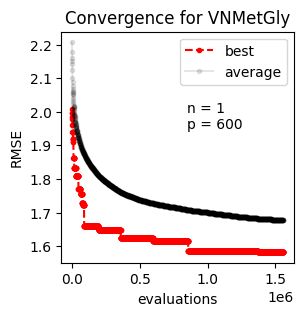

In [8]:
results = [np.concatenate(l,axis=0) for l in logs]
plt.figure(figsize=(3,3))
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,2],'.r--', label = 'best') for res in results]
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,4],'.k-', alpha = 0.1, label = 'average') for res in results]
# plt.xscale('log')

# test_evals = np.arange(1,len(np.squeeze(np.array(test_fit)))*10,10)
# plt.plot(test_evals, np.squeeze(np.array(test_fit)).mean(axis=1),'or-', alpha = 0.4, label = 'average, test')
# plt.plot(test_evals, np.squeeze(np.array(test_fit)).min(axis=1),'or-', label = 'best, test')

# plt.yscale('log')
plt.ylabel('RMSE')
plt.xlabel('evaluations')
plt.title('Convergence for VNMetGly')  
plt.legend()
plt.text(850000, 1.95, 'n = 1 \np = 600');

In [54]:
with open('src/frenda_brenda/Files/Reduced Complexity/240621_VN_Metabolism_Gly.txt', 'r') as f:
    antimony = f.read()

x = [*list(myprob._unscale(pops[0].champion_x)),variables_230623['empty']['dilution_factor']]
for p,v in zip(parameter_labels+['dilution_factor'], x):
    start = antimony.find(p+' =')
    end = start + antimony[start:start+50].find(';')
    antimony = antimony.replace(antimony[start:end], p+' ='+str(v))

with open('results/240621_VNMetGly_AllData/240621_VN_Metabolism_Gly_fitted.sbml', 'w') as f:
    f.write(te.loada(antimony).getSBML())

In [7]:
myprob._setup_rr()

all_results = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [myprob]] 
for k,c in enumerate(pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:6],:]):
    res_dict = myprob._simulate(myprob._unscale(c))
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[0], res_dict, myprob.metadata, myprob.model_stuff)]


/tmp/ipykernel_190/550785019.py:16: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.

/tmp/ipykernel_190/550785019.py:36: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.



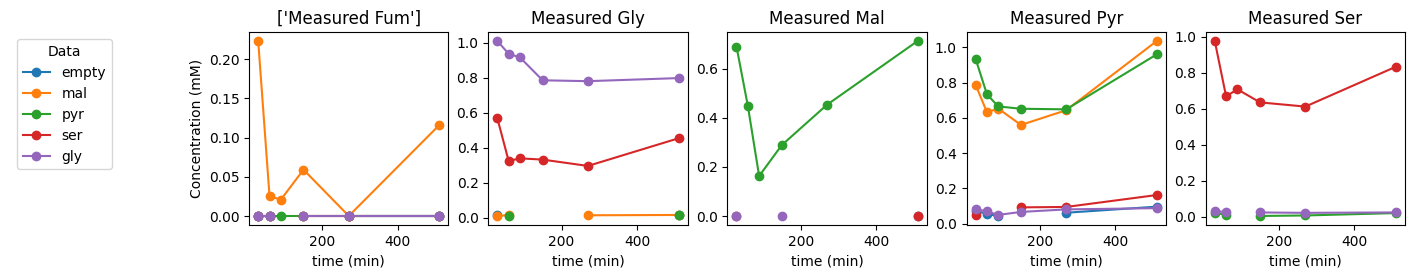

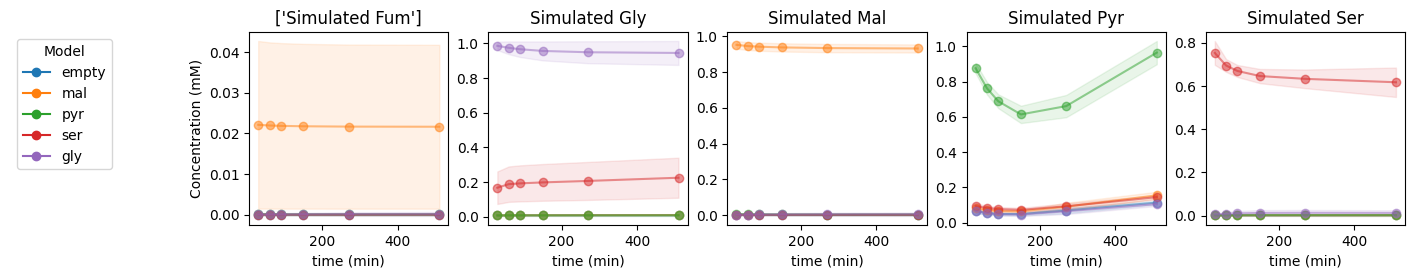

In [8]:
metadata = metadata_230623
measurements = measurements_230623
plt.figure(figsize=(18,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,len(metadata['measurement_labels'])+1,i+2)
        plt.plot(metadata['timepoints'][s]/60, measurements[s][:,i],'-o')
        plt.title('Measured ' + translate_kegg([m])[0])
        plt.xlabel('time (min)')
        if i == 0: plt.ylabel('Concentration (mM)')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Data')
plt.gca().axis('off')
plt.tight_layout()

for [results] in all_results:
    plt.figure(figsize=(18,2.5))
    for s in metadata['sample_labels']:
        for i,m in enumerate(metadata['measurement_labels']):
            plt.subplot(1,len(metadata['measurement_labels'])+1,i+2)
            if s in results.keys():
                mean = np.mean(results[s],0)[:,i]
                std = np.std(results[s],0)[:,i]
                p = plt.plot(metadata['timepoints'][s]/60, mean,'-o', alpha = 0.5)
                plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
            plt.title('Simulated ' + translate_kegg([m])[0])
            plt.xlabel('time (min)')
            if i == 0: plt.ylabel('Concentration (mM)')

    plt.subplot(1,5,1)
    [plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels'] if s in results.keys()]
    plt.legend(results.keys(), loc='upper left', title='Model')
    plt.gca().axis('off')
    plt.tight_layout()
    

In [75]:
all_rates = {s:[] for s in metadata_230623['sample_labels']}
all_rates_F = {s:[] for s in metadata_230623['sample_labels']}
all_rates_R = {s:[] for s in metadata_230623['sample_labels']}
all_concentrations = {s:[] for s in metadata_230623['sample_labels']}
# c = pops[0].champion_x
for t in metadata_230623['timepoints']['empty'][1:]:
    from roadrunner import Config, RoadRunner, Logger
    Logger.disableLogging()
    Config.setValue(Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, True)
    Config.setValue(Config.LOADSBMLOPTIONS_RECOMPILE, False) 
    Config.setValue(Config.LLJIT_OPTIMIZATION_LEVEL, 4)
    Config.setValue(Config.LLVM_SYMBOL_CACHE, True)
    Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_GVN, True)
    Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_CFG_SIMPLIFICATION, True)
    Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_INSTRUCTION_COMBINING, True)
    Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_DEAD_INST_ELIMINATION, True)
    Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_DEAD_CODE_ELIMINATION, True)
    Config.setValue(Config.LOADSBMLOPTIONS_OPTIMIZE_INSTRUCTION_SIMPLIFIER, True)
    Config.setValue(Config.SIMULATEOPTIONS_COPY_RESULT, True)

    
    for r,ms, data, metadata, variables in zip(myprob.r, myprob.model_stuff, myprob.data, myprob.metadata, myprob.variables):
        # this is suboptimal as it only needs to happen once...
        p_variables = {sample:{k:v for k,v in var.items() if k in ms.r_parameter_labels} for sample,var in variables.items()}
        results = {sample:data[sample]*(-np.inf) for sample in metadata['sample_labels']}

        for sample in metadata['sample_labels']:

            avg_rates = np.zeros((len(r.getReactionIds()))) 
            avg_rates_F = np.zeros((len(r.getReactionIds()))) 
            avg_rates_R = np.zeros((len(r.getReactionIds()))) 
            avg_concentrations = np.zeros((len(r.getFloatingSpeciesIds()))) 
            
            for _,c in enumerate(pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:6],:]):
                x = myprob._unscale(c)
                r.model.setGlobalParameterValues([*ms.parameter_order, *ms.variable_order[sample]], [*x, *p_variables[sample].values()])
                r.reset()
                # set init concentrations
                for label, value in variables[sample].items():
                    if not np.isnan(value):
                        if label in ms.species_labels:
                            if 'EC' not in label:
                                r.setValue('['+label+']', value)
                            else: 
                                r.setValue('['+label+']', value*p_variables[sample]['dilution_factor']*x[-1]) # this is a bit obtuse: [plasmid] * DF * rel1

                avg_concentrations = avg_concentrations + r.simulate(0,t,myprob.cvode_timepoints)[-1,1:].__array__()/6
                avg_rates = avg_rates + r.getReactionRates()/6
                avg_rates_F = avg_rates_F + np.array([r.getValue(p+'_f') for p in r.getReactionIds()])/6
                avg_rates_R = avg_rates_R + np.array([r.getValue(p+'_r') for p in r.getReactionIds()])/6
                r.resetToOrigin()

            all_concentrations[sample].append(avg_concentrations)
            all_rates[sample].append(avg_rates)
            all_rates_F[sample].append(avg_rates_F)
            all_rates_R[sample].append(avg_rates_R)

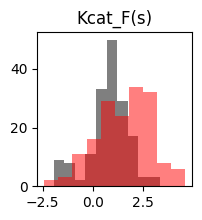

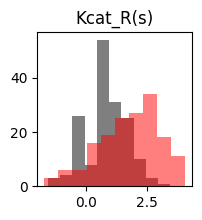

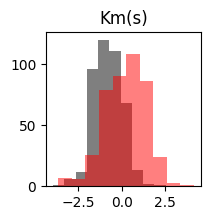

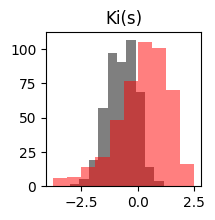

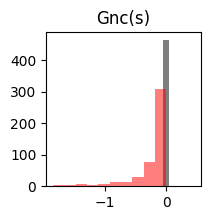

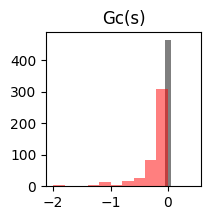

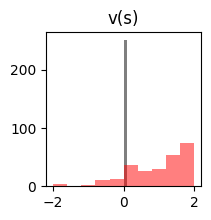

In [33]:
for k in ['Kcat_F','Kcat_R','Km','Ki','Gnc','Gc','v']:
    index = [k in p for p in parameter_labels]
    plt.figure(figsize = (2,2))
    plt.title(k+'(s)')
    plt.hist(np.log10(p_initial[index]), color = 'k', alpha = 0.5)
    plt.hist(np.log10(myprob._unscale(pops[0].champion_x)[index]), color = 'r', alpha = 0.5)

([], [])

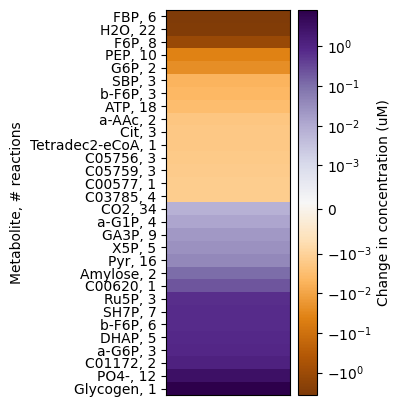

In [40]:
import matplotlib.colors as colors
most_change = np.argsort(all_concentrations['empty'][-1]-all_concentrations['empty'][0])[[*np.arange(15),*np.arange(-15,0)]]
plt.figure(figsize=(2,5))
plt.imshow((all_concentrations['empty'][-1][most_change]-all_concentrations['empty'][0][most_change])[np.newaxis].T,aspect='auto',cmap='PuOr',norm=colors.SymLogNorm(0.001))
plt.colorbar(label='Change in concentration (uM)')
plt.yticks(np.arange(len(most_change)),[translate_kegg([s])[0]+', '+str(len(np.where((myprob.r[0].getFullStoichiometryMatrix()[s]))[0])) for s in np.array(r_prefit.getFloatingSpeciesIds())[most_change]])
plt.ylabel('Metabolite, # reactions')
plt.xticks([])

In [41]:
r_met = np.argsort(np.abs(rates).sum(axis=0))[-20:]

size = np.ceil(len(r_met)/3)+1
fig, ax = plt.subplots(figsize=(2, size))
fig.subplots_adjust(wspace=0.5)

im= ax.imshow(np.array(rates).T[r_met],aspect='auto',cmap='PuOr',norm=colors.SymLogNorm(0.001))
ax.set_ylabel('Reactants')
ax.set_xlabel('Time (mins)')
ax.set_xticks(np.arange(0,len(rates),1), labels = np.int16(metadata_230623['timepoints']['empty'][1:]/60))

ax.set_yticks(np.arange(0,len(r_met),1), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(np.arange(0,len(r_met),1), labels = [' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
ax2.set_ylabel('Products')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('top', size=0.2, pad=0.5)
cax.xaxis.set_ticks_position("both")
fig.colorbar(im, cax=cax, orientation='horizontal', label = 'Rate')

NameError: name 'rates' is not defined

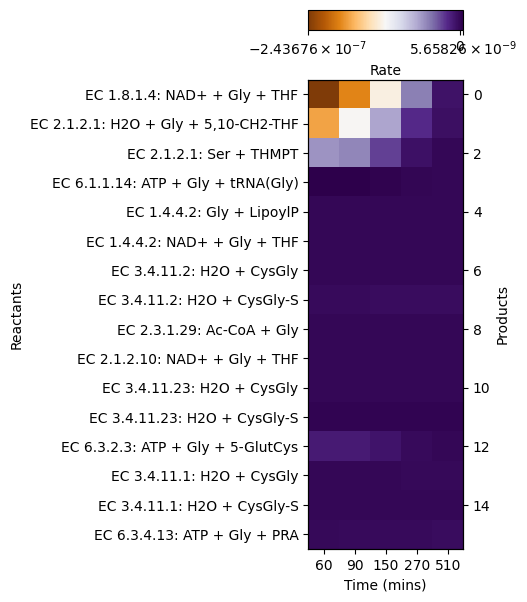

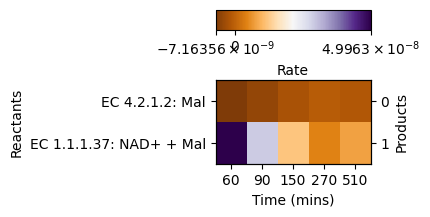

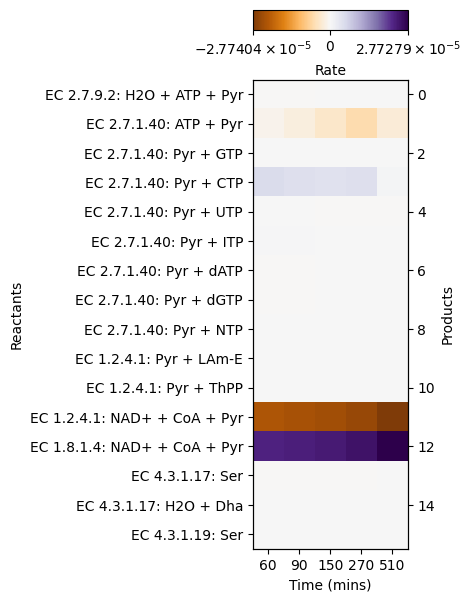

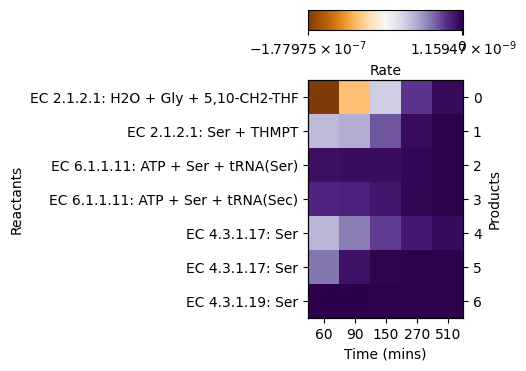

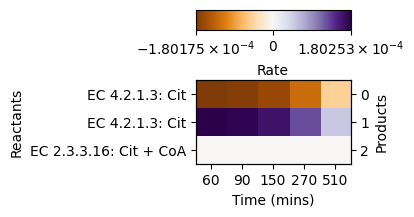

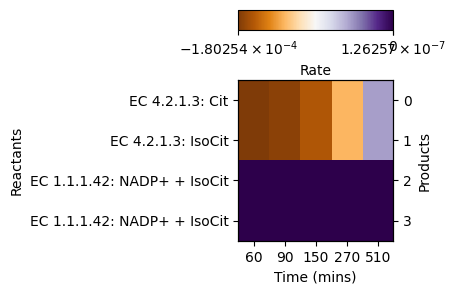

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
kegg_labels = pd.read_csv('kegg_labels.csv', index_col = 0)
translate_kegg = lambda X: [kegg_labels.loc[x].values[0] for x in X]

rates = all_rates['empty']
# index of reactions involving metabolites
for s in ['C00037', 'C00149', 'C00022', 'C00065', 'C00158','C00311']:
    r_met = np.where(np.abs(myprob.r[0].getFullStoichiometryMatrix()[s]))[0]

    size = np.ceil(len(r_met)/3)+1
    fig, ax = plt.subplots(figsize=(2, size))
    fig.subplots_adjust(wspace=0.5)

    im= ax.imshow(np.array(rates).T[r_met],aspect='auto',cmap='PuOr',norm=colors.SymLogNorm(0.001))
    ax.set_ylabel('Reactants')
    ax.set_xlabel('Time (mins)')
    ax.set_xticks(np.arange(0,len(rates),1), labels = np.int16(metadata['timepoints']['empty'][1:]/60))

    ax.set_yticks(np.arange(0,len(r_met),1), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    # ax2.set_yticks(np.arange(0,len(r_met),1), labels = [' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(" ",'').split(';')))) for r in np.array(r_prefit.getReactionIds())[r_met]])
    ax2.set_ylabel('Products')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('top', size=0.2, pad=0.5)
    cax.xaxis.set_ticks_position("both")
    fig.colorbar(im, cax=cax, orientation='horizontal', label = 'Rate')

#Required to remove some white border

In [117]:
import matplotlib.colors as mcolors


def symmetrical_colormap(cmap_settings, new_name = None ):
    ''' This function take a colormap and create a new one, as the concatenation of itself by a symmetrical fold.
    '''
    # get the colormap
    cmap = plt.get_cmap(*cmap_settings)
    if not new_name:
        new_name = "sym_"+cmap_settings[0]  # ex: 'sym_Blues'
    
    # this defined the roughness of the colormap, 128 fine
    n= 128 
    
    # get the list of color from colormap
    colors_r = cmap(np.linspace(0, 1, n))    # take the standard colormap # 'right-part'
    colors_l = colors_r[::-1]                # take the first list of color and flip the order # "left-part"

    # combine them and build a new colormap
    colors = np.vstack((colors_l, colors_r))
    mymap = mcolors.LinearSegmentedColormap.from_list(new_name, colors)

    return mymap

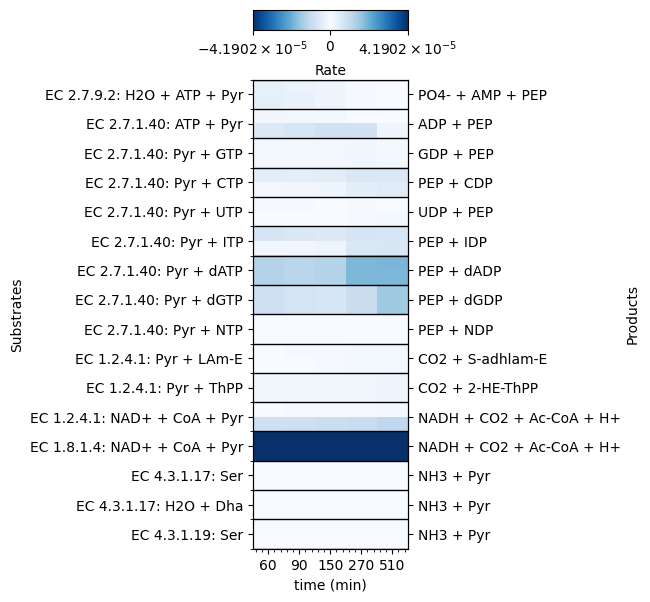

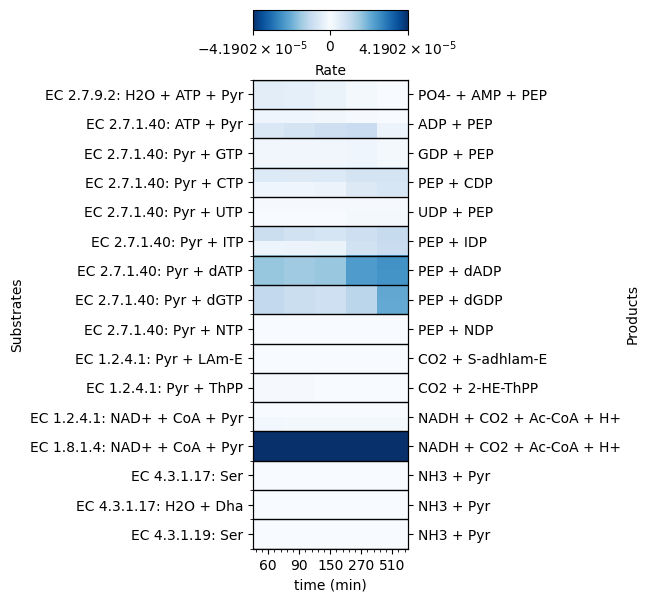

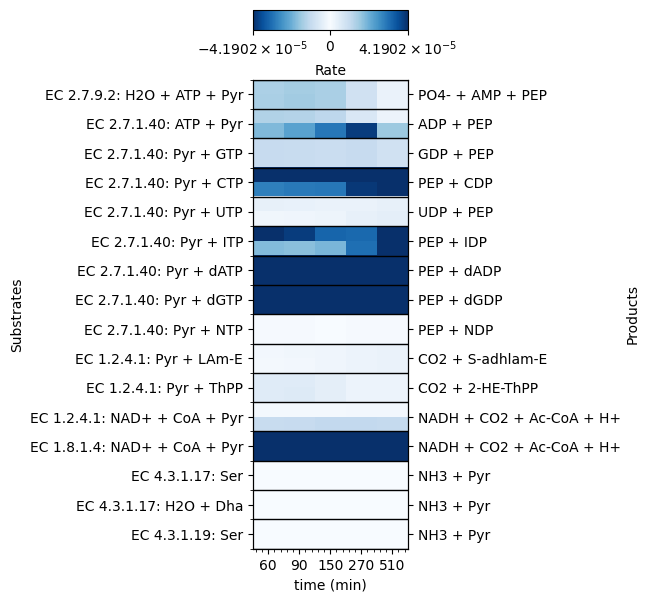

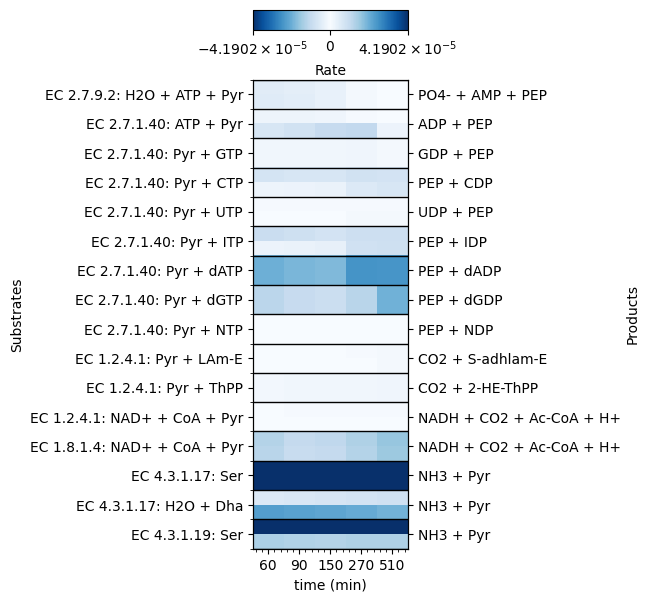

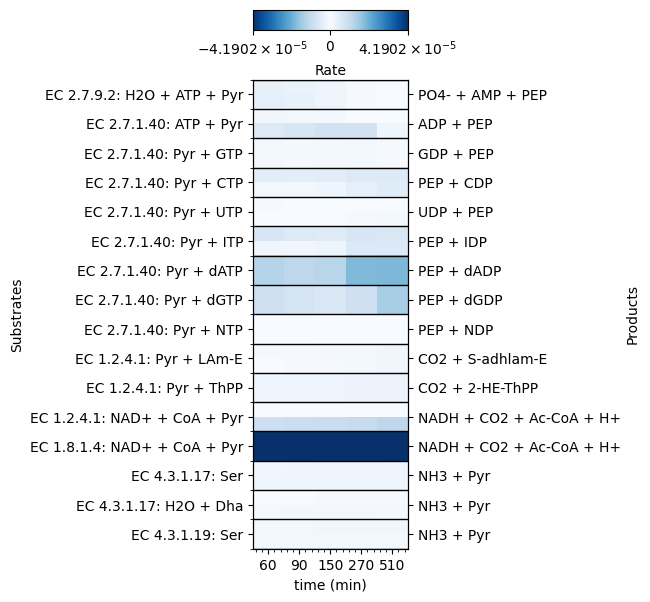

In [142]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.colors as colors
kegg_labels = pd.read_csv('kegg_labels.csv', index_col = 0)
translate_kegg = lambda X: [kegg_labels.loc[x].values[0] for x in X]

s = 'C00022'
r_met = np.where(np.abs(myprob.r[0].getFullStoichiometryMatrix()[s]))[0]
v = np.max(np.abs([np.array(rates).T[r_met] for rates in all_rates.values()]))
# index of reactions involving metabolites
for r_f,r_r in zip(all_rates_F.values(),all_rates_R.values()):
    size = np.ceil(len(r_met)/3)+1
    fig, ax = plt.subplots(figsize=(2, size))
    fig.subplots_adjust(wspace=0.5)

    F = np.array(r_f).T[r_met]
    R = np.array(r_r).T[r_met]

    FR = np.zeros((len(r_met)*2,len(F.T)))
    for i,k in zip(np.arange(0,len(r_met)),np.arange(0,len(r_met)*2,2)):
        FR[k,:] = F[i,:]
        FR[k+1,:] = -R[i,:]

    im= ax.imshow(FR,aspect='auto',cmap=symmetrical_colormap(cmap_settings= ('Blues', None)),norm=colors.SymLogNorm(0.001,vmin = -v, vmax = v))
    ax.set_ylabel('Substrates')
    ax.set_xticks(np.arange(0,len(r_f),1), labels = np.int16(metadata['timepoints']['empty'][1:]/60))
    ax.set_xlabel('time (min)')

    ax.set_yticks(np.arange(0.5,len(r_met)*2,2), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(np.arange(0.5,len(r_met)*2,2), labels = [' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(" ",'').split(';')))) for r in np.array(r_prefit.getReactionIds())[r_met]])
    ax2.set_ylabel('Products')

    # Gridlines based on minor ticks
    ax.grid(which='minor', axis = 'y', color='k', linestyle='-', linewidth=1)
    ax.minorticks_on()
    # Minor ticks
    ax.set_yticks(np.arange(-0.5,len(r_met)*2,2), minor=True)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('top', size=0.2, pad=0.5)
    cax.xaxis.set_ticks_position("both")
    fig.colorbar(im, cax=cax, orientation='horizontal', label = 'Rate')

#Required to remove some white border

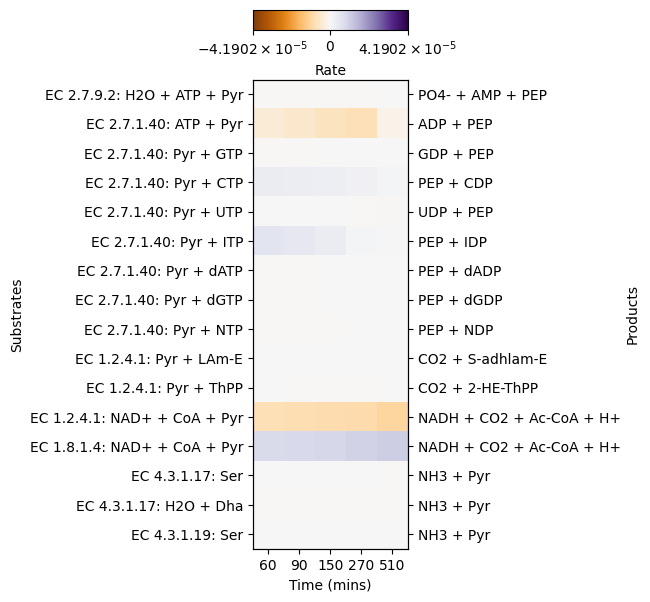

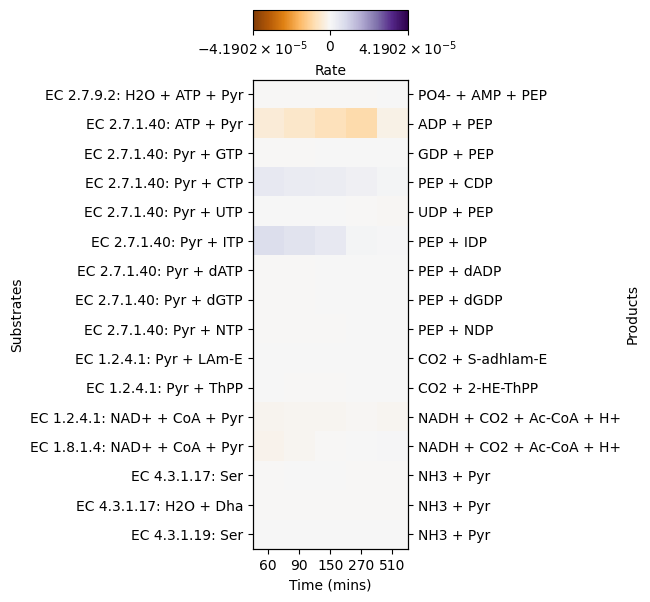

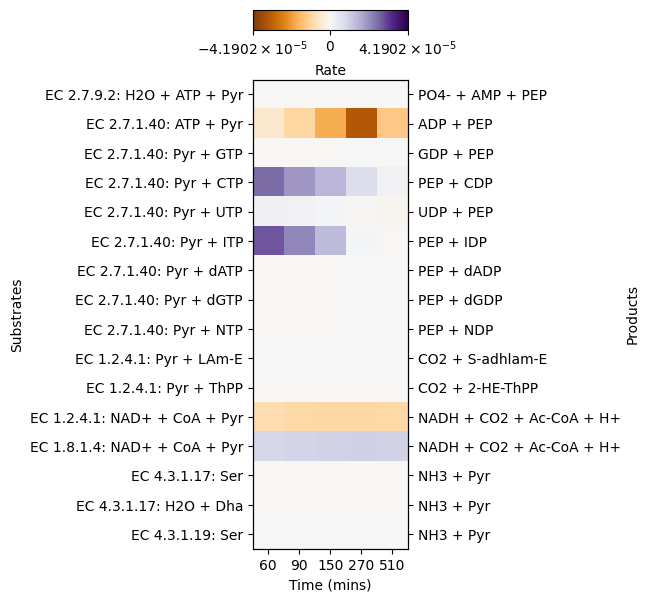

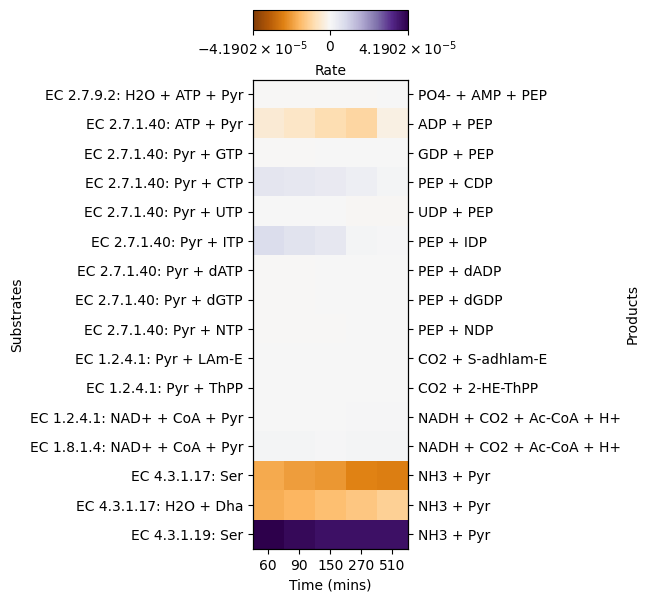

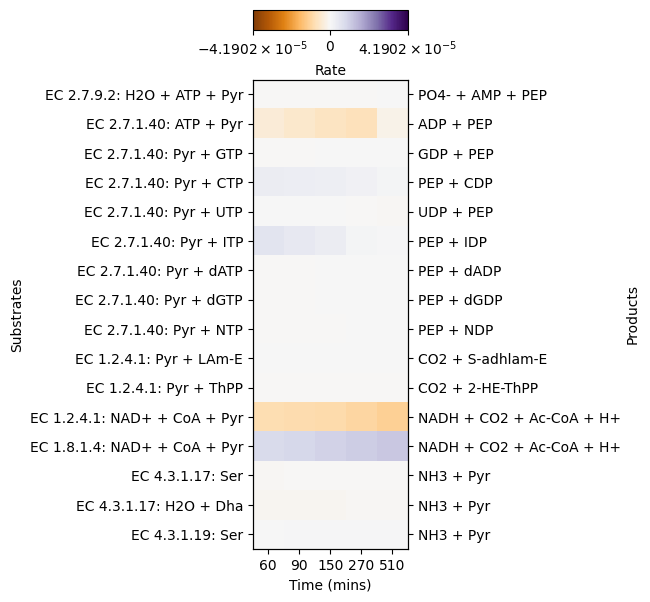

In [110]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
kegg_labels = pd.read_csv('kegg_labels.csv', index_col = 0)
translate_kegg = lambda X: [kegg_labels.loc[x].values[0] for x in X]

s = 'C00022'
r_met = np.where(np.abs(myprob.r[0].getFullStoichiometryMatrix()[s]))[0]
v = np.max(np.abs([np.array(rates).T[r_met] for rates in all_rates.values()]))
# index of reactions involving metabolites
for rates in all_rates.values():
    size = np.ceil(len(r_met)/3)+1
    fig, ax = plt.subplots(figsize=(2, size))
    fig.subplots_adjust(wspace=0.5)

    im= ax.imshow(np.array(rates).T[r_met],aspect='auto', cmap='PuOr',norm=colors.SymLogNorm(0.001,vmin = -v, vmax = v))
    ax.set_ylabel('Substrates')
    ax.set_xlabel('Time (mins)')
    ax.set_xticks(np.arange(0,len(rates),1), labels = np.int16(metadata['timepoints']['empty'][1:]/60))

    ax.set_yticks(np.arange(0,len(r_met),1), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(np.arange(0,len(r_met),1), labels = [' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(" ",'').split(';')))) for r in np.array(r_prefit.getReactionIds())[r_met]])
    ax2.set_ylabel('Products')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('top', size=0.2, pad=0.5)
    cax.xaxis.set_ticks_position("both")
    fig.colorbar(im, cax=cax, orientation='horizontal', label = 'Rate')

#Required to remove some white border

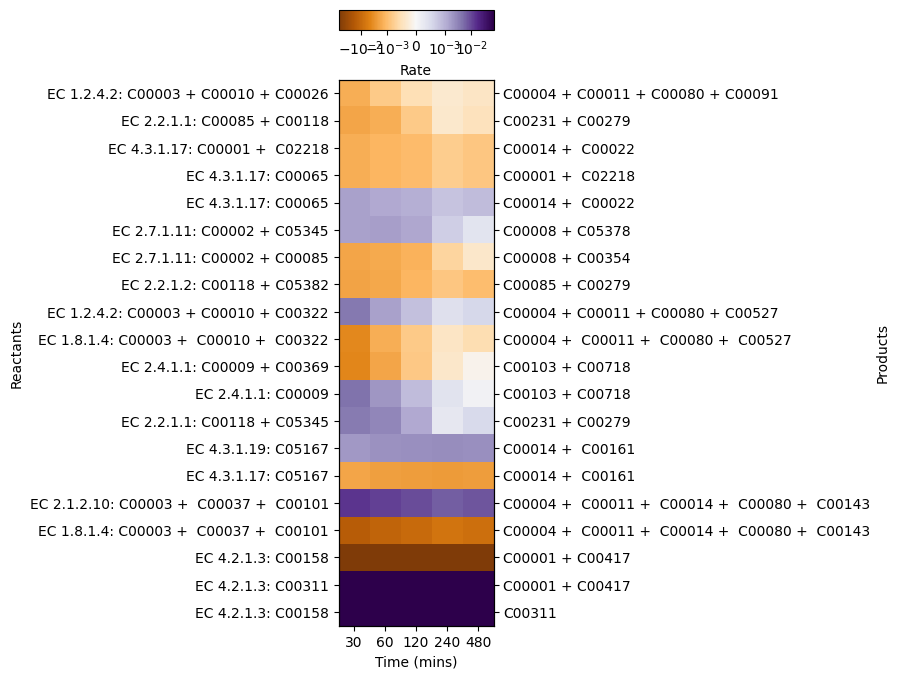

In [146]:
r_met = np.argsort(np.abs(rates).sum(axis=0))[-20:]

size = np.ceil(len(r_met)/3)+1
fig, ax = plt.subplots(figsize=(2, size))
fig.subplots_adjust(wspace=0.5)

im= ax.imshow(np.array(rates).T[r_met],aspect='auto',cmap='PuOr',norm=colors.SymLogNorm(0.001))
ax.set_ylabel('Reactants')
ax.set_xlabel('Time (mins)')
ax.set_xticks(np.arange(0,len(rates),1), labels = np.int16(metadata['timepoints']['empty'][1:]/60))

ax.set_yticks(np.arange(0,len(r_met),1), labels = ['EC '+model_rxns.loc[model_rxns['Label'] == r]['EC'].values[0] +': '+' + '.join((translate_kegg(model_rxns.loc[model_rxns['Label'] == r]['Substrates'].values[0].replace(" ",'').split(';')))) for r in np.array(r.getReactionIds())[r_met]])
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(np.arange(0,len(r_met),1), labels = [model_rxns.loc[model_rxns['Label'] == r]['Products'].values[0].replace(';',' + ') for r in np.array(r.getReactionIds())[r_met]])
ax2.set_ylabel('Products')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('top', size=0.2, pad=0.5)
cax.xaxis.set_ticks_position("both")
fig.colorbar(im, cax=cax, orientation='horizontal', label = 'Rate')

In [64]:
np.array(r.getReactionIds())[np.argsort(np.abs(rates).sum(axis=0))[-20:]]

array(['R58', 'R70', 'R171', 'R169', 'R168', 'R6', 'R5', 'R75', 'R55',
       'R149', 'R138', 'R137', 'R71', 'R174', 'R170', 'R162', 'R147',
       'R48', 'R49', 'R47'], dtype='<U4')

In [170]:
top_params = np.array(list(map(myprob._unscale, top_pop.get_x())))
mean_params = top_params.mean(0)
std_params = top_params.std(0)

In [148]:
r_prefit.getGlobalParameterIds()[1200]

'Gi_C00988_EC42111'

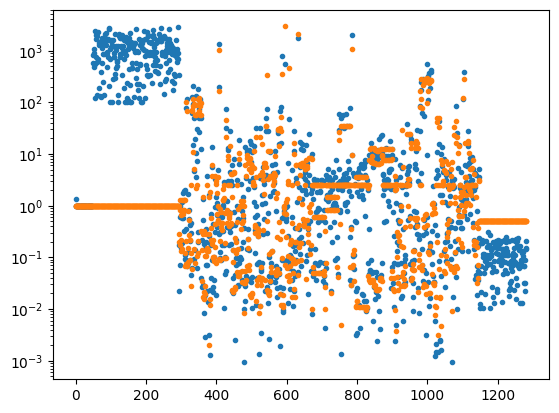

In [147]:
plt.plot(myprob.r.getGlobalParameterValues(),'.')
plt.plot(r_prefit.getGlobalParameterValues(),'.')
plt.yscale('log')

Text(0.5, 0, 'KcatF/R')

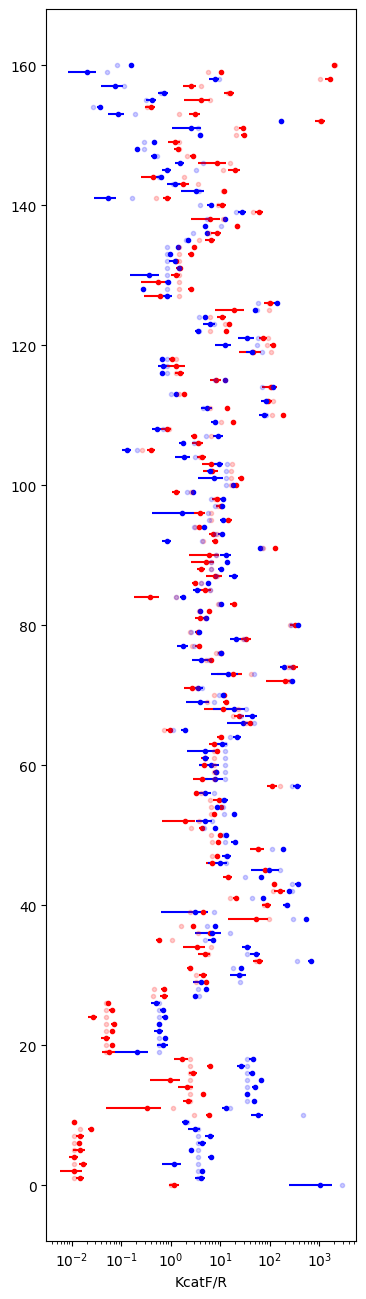

In [250]:
order = (np.argsort(p_initial[psF]/p_initial[psR]))
psF = [i for i,p in enumerate(parameter_labels) if 'Kcat_F' in p]
psR = [i for i,p in enumerate(parameter_labels) if 'Kcat_R' in p]
plt.figure(figsize=(4,16))
plt.errorbar(mean_params[psF][order],np.arange(len(psF)),xerr=std_params[psF][order]/2,fmt='r.')
plt.errorbar(mean_params[psR][order],np.arange(len(psR)),xerr=std_params[psR][order]/2,fmt='b.')
plt.errorbar(p_initial[psF][order],np.arange(len(psF)),fmt='r.', alpha = 0.2)
plt.errorbar(p_initial[psR][order],np.arange(len(psR)),fmt='b.', alpha = 0.2)
plt.xscale('log')
plt.xlabel('KcatF/R')

Text(0.5, 0, 'vCxxxx')

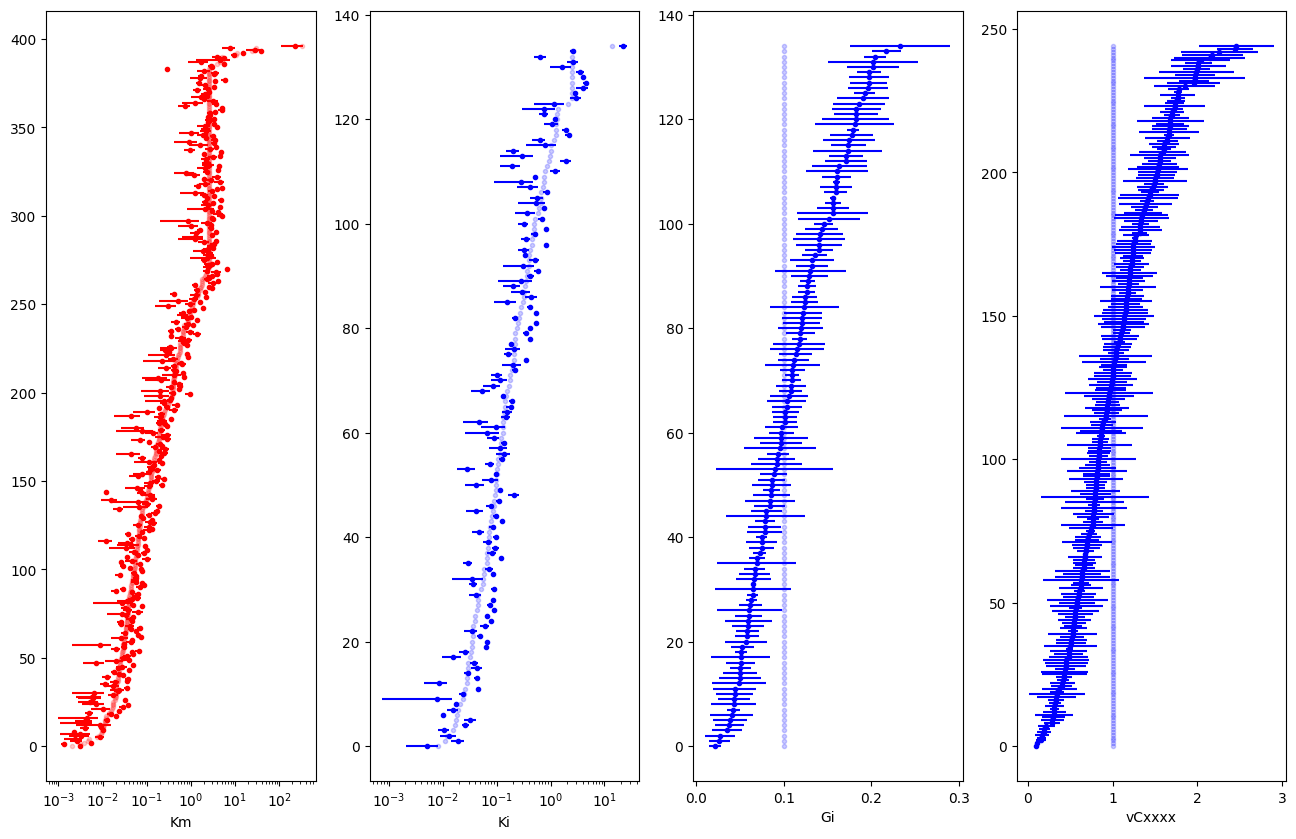

In [203]:
psKm = [i for i,p in enumerate(parameter_labels) if 'Km' in p]
order = np.argsort(p_initial[psKm])

plt.figure(figsize=(16,10))
plt.subplot(141)
plt.errorbar(mean_params[psKm][order],np.arange(len(psKm)),xerr=std_params[psKm][order]/2,fmt='r.')
plt.errorbar(p_initial[psKm][order],np.arange(len(psKm)),fmt='r.', alpha = 0.2)
plt.xscale('log')
plt.xlabel('Km')

psKi= [i for i,p in enumerate(parameter_labels) if 'Ki' in p]
order = np.argsort(p_initial[psKi])
plt.subplot(142)
plt.errorbar(mean_params[psKi][order],np.arange(len(psKi)),xerr=std_params[psKi][order]/2,fmt='b.')
plt.errorbar(p_initial[psKi][order],np.arange(len(psKi)),fmt='b.', alpha = 0.2)
plt.xscale('log')
plt.xlabel('Ki')

psGi= [i for i,p in enumerate(parameter_labels) if 'Gi' in p]
order = np.argsort(mean_params[psGi])
plt.subplot(143)
plt.errorbar(mean_params[psGi][order],np.arange(len(psGi)),xerr=std_params[psGi][order]/2,fmt='b.')
plt.errorbar(p_initial[psGi][order],np.arange(len(psGi)),fmt='b.', alpha = 0.2)
# plt.xscale('log')
plt.xlabel('Gi')

plt.subplot(144)
psKi= [i for i,p in enumerate(parameter_labels) if 'v' in p]
order = np.argsort(mean_params[psKi])
plt.errorbar(mean_params[psKi][order],np.arange(len(psKi)),xerr=std_params[psKi][order]/2,fmt='b.')
plt.errorbar(p_initial[psKi][order],np.arange(len(psKi)),fmt='b.', alpha = 0.2)
# plt.xscale('log')
plt.xlabel('vCxxxx')

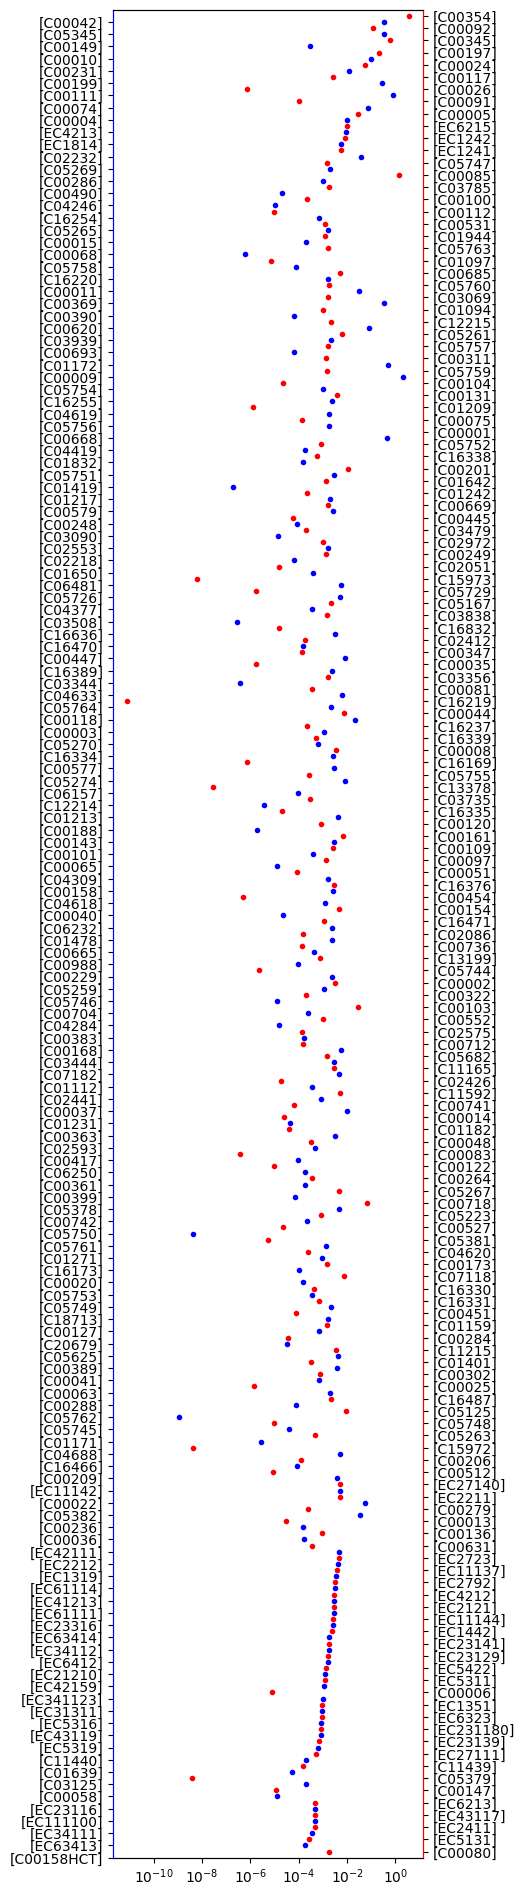

In [46]:
plt.figure(figsize=(4,24))
order = np.argsort([r_prefit[s] for s in r_prefit.getFloatingSpeciesConcentrationIds()])
plt.errorbar(all_concentrations['empty'][0][order][0::2],np.arange(len(order))[0::2], fmt='b.')
plt.xscale('log')
plt.yticks(np.arange(len(order))[0::2],np.array(r_prefit.getFloatingSpeciesConcentrationIds())[order][0::2]);
plt.ylim([0,len(order)])
ax2 = plt.gca().twinx()
ax2.set_yticks(np.arange(len(order))[1::2])
ax2.set_yticklabels(np.array(r_prefit.getFloatingSpeciesConcentrationIds())[order][1::2])
ax2.errorbar(all_concentrations['empty'][0][order][1::2],np.arange(len(order))[1::2], fmt='r.')
ax2.set_ylim([0,len(order)])
ax2.spines['right'].set_color('r')
ax2.spines['left'].set_color('b')

In [252]:
pops[0].get_x().shape

(600, 2408)

In [43]:
from sklearn.feature_selection import r_regression, mutual_info_regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

pcorr = np.abs(r_regression(pops[0].get_x(), np.squeeze(pops[0].get_f())))
mi = mutual_info_regression(pops[0].get_x(), np.squeeze(pops[0].get_f()))
fi = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=100).fit(pops[0].get_x(), np.squeeze(pops[0].get_f())).feature_importances_

KeyboardInterrupt: 

In [48]:
top_n = 300
pcorr_order = np.argsort(pcorr)[-top_n:]
mi_order = np.argsort(mi)[-top_n:]
fi_order = np.argsort(fi)[-top_n:]
top_idx = [i for i in np.arange(len(parameter_labels)) if (i in pcorr_order) and (i in mi_order) and (i in fi_order)]

pcorr_order = np.argsort(pcorr)[:top_n]
mi_order = np.argsort(mi)[:top_n]
fi_order = np.argsort(fi)[:top_n]
bot_idx = [i for i in np.arange(len(parameter_labels)) if (i in pcorr_order) and (i in mi_order) and (i in fi_order)]

In [219]:
dtype = [('var', 'S10'), ('C', 'S10'), ('EC', 'S10')]
np.array([tuple(p.split('_')) for p in parameter_labels],dtype=dtype)

ValueError: could not assign tuple of length 1 to structure with 3 fields.

In [207]:
np.sort([np.array(parameter_labels)[top_idx]])

array([['Gi_C00111_EC41213', 'Gi_C01213_EC63414', 'Gi_C11592_EC11137',
        'Kcat_F_R106', 'Kcat_F_R169', 'Kcat_F_R32', 'Kcat_F_R34',
        'Kcat_F_R65', 'Kcat_R_R137', 'Kcat_R_R65', 'Ki_C00010_EC11137',
        'Ki_C00020_EC31311', 'Ki_C00024_EC11137', 'Ki_C00036_EC11137',
        'Ki_C00199_EC11144', 'Ki_C05625_EC27140', 'Ki_C20679_EC31311',
        'Km_C00003_EC11137', 'Km_C00003_EC1814', 'Km_C00004_EC11137',
        'Km_C00004_EC1319', 'Km_C00004_EC1814', 'Km_C00011_EC1241',
        'Km_C00036_EC11137', 'Km_C00037_EC34112', 'Km_C00101_EC2121',
        'Km_C00149_EC11137', 'Km_C00158_EC4213', 'Km_C00369_EC2411',
        'Km_C01271_EC111100', 'Km_C05744_EC231180', 'Km_C05749_EC1319',
        'Km_C06157_EC1242', 'rel0', 'v129', 'v145', 'v149', 'v160',
        'v163', 'v6', 'v72', 'v98']], dtype='<U18')

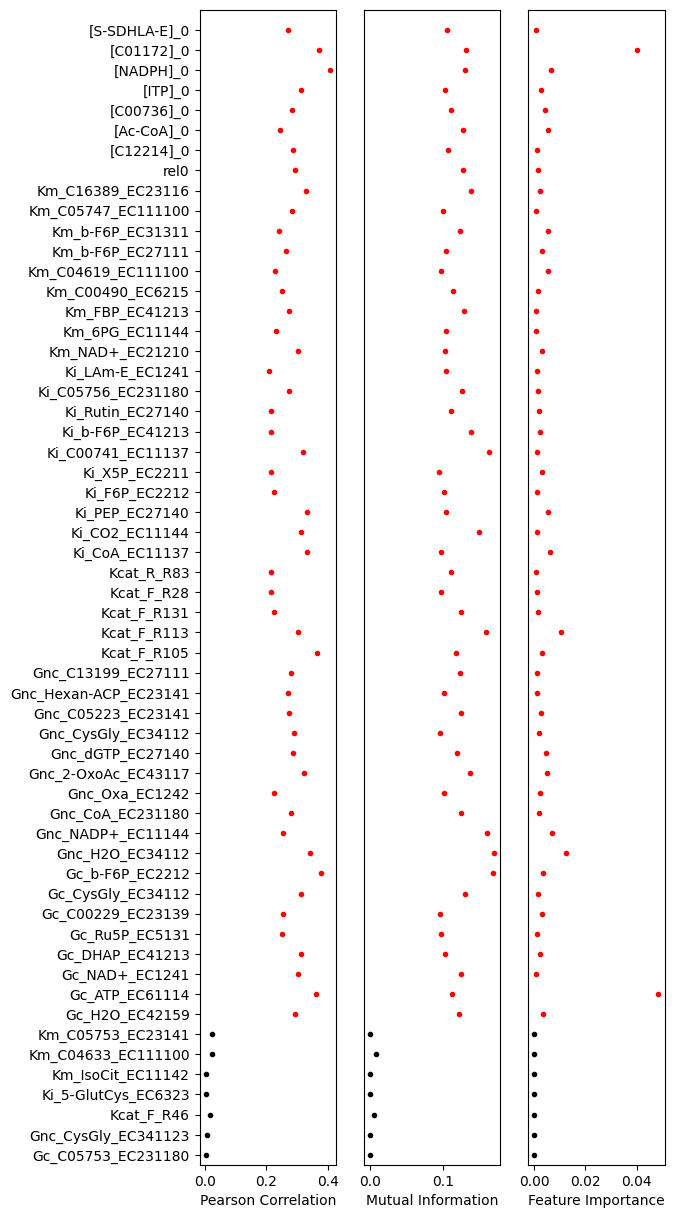

In [51]:
translate_v = {v:m for v,m in zip(metabolites_labels, metabolites)}
v_to_label = lambda x: '['+translate_kegg([translate_v[x]])[0]+"]_0"

plt.figure(figsize=(6,15))
labels = ['Pearson Correlation','Mutual Information','Feature Importance']
for i,var in enumerate([pcorr, mi, fi]):
    plt.subplot(1,3,i+1)
    order = np.array(top_idx)[np.argsort(np.array(parameter_labels)[top_idx])]
    plt.errorbar(var[order],np.arange(len(bot_idx),len(top_idx + bot_idx)), fmt='r.')

    order2 = np.array(bot_idx)[np.argsort(np.array(parameter_labels)[bot_idx])]
    plt.errorbar(var[order2],np.arange(0,len(bot_idx)), fmt='k.')

    if i == 0:
        ylabels = list(np.array(parameter_labels)[order2])+list(np.array(parameter_labels)[order])
        for k,l in enumerate(ylabels):
            if 'v' in l:
                ylabels[k] = v_to_label(l)

            elif '_C' in l:
                kg = l.split('_')[1]
                ylabels[k] = l.replace(kg,translate_kegg([kg])[0])

        plt.yticks(np.arange(len(top_idx + bot_idx)),ylabels);
    else:
        plt.yticks([])
    plt.ylim([-0.5,len(top_idx + bot_idx)])
    plt.xlabel(labels[i])

In [164]:
translate_v['v228']

'C02051_0'

[]

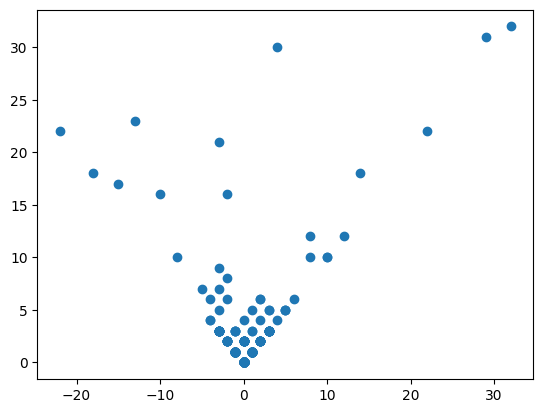

In [23]:
r.getFullStoichiometryMatrix()plt.plot(().sum(axis=1),np.abs(r.getFullStoichiometryMatrix()).sum(axis=1),'o')
plt.plot()

In [57]:
# index of species involved in reactions involving pyruvate
s_pyr = np.where(np.abs(r.getFullStoichiometryMatrix()[:,r_pyr]).sum(1))[0]

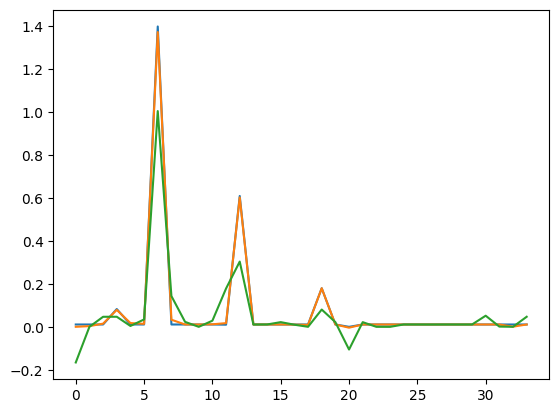

In [70]:
r.resetToOrigin()
plt.plot(r.getFloatingSpeciesConcentrations()[s_pyr])
r.simulate(0, 0.0001, 1000)
plt.plot(r.getFloatingSpeciesConcentrations()[s_pyr])
r.simulate(0, 1000, 1000)
plt.plot(r.getFloatingSpeciesConcentrations()[s_pyr])

array(['R26', 'R27', 'R28', 'R29', 'R30', 'R31', 'R32', 'R33', 'R34',
       'R43', 'R44', 'R45', 'R146', 'R168', 'R171', 'R173'], dtype='<U4')

In [46]:
top = pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:6],:]
mean = np.array(top.mean(axis=0))
std = np.array(top.std(axis=0))

xis = np.apply_along_axis(myprob._scale, 0, np.array([(np.random.uniform(p/w,p*w, 600)) for p,w in zip(p_initial,widths)])).T
xi = np.array([(np.random.uniform(p/w,p*w, 600)) for p,w in zip(p_initial,widths)]).T

plot_labels = np.array(parameter_labels)

index = (np.sqrt((mean-xis.mean(0))**2) > 0.5)*(std<0.2)

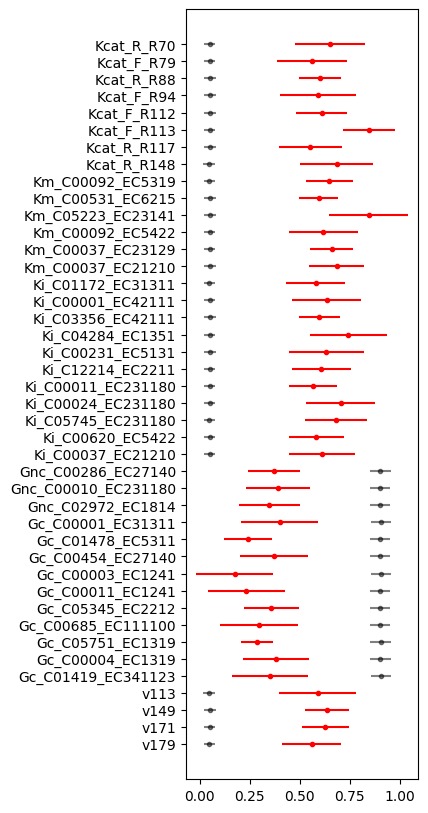

In [39]:
plt.figure(figsize=(3,10))
plt.errorbar(mean[index][::-1],range(sum(index)),xerr=std[index][::-1], fmt='r.')
plt.errorbar(xis.mean(0)[index][::-1],range(sum(index)),xerr=xis.std(0)[index][::-1], fmt='k.', alpha = 0.5)

plt.yticks(range(sum(index)),plot_labels[index][::-1], rotation = 0);



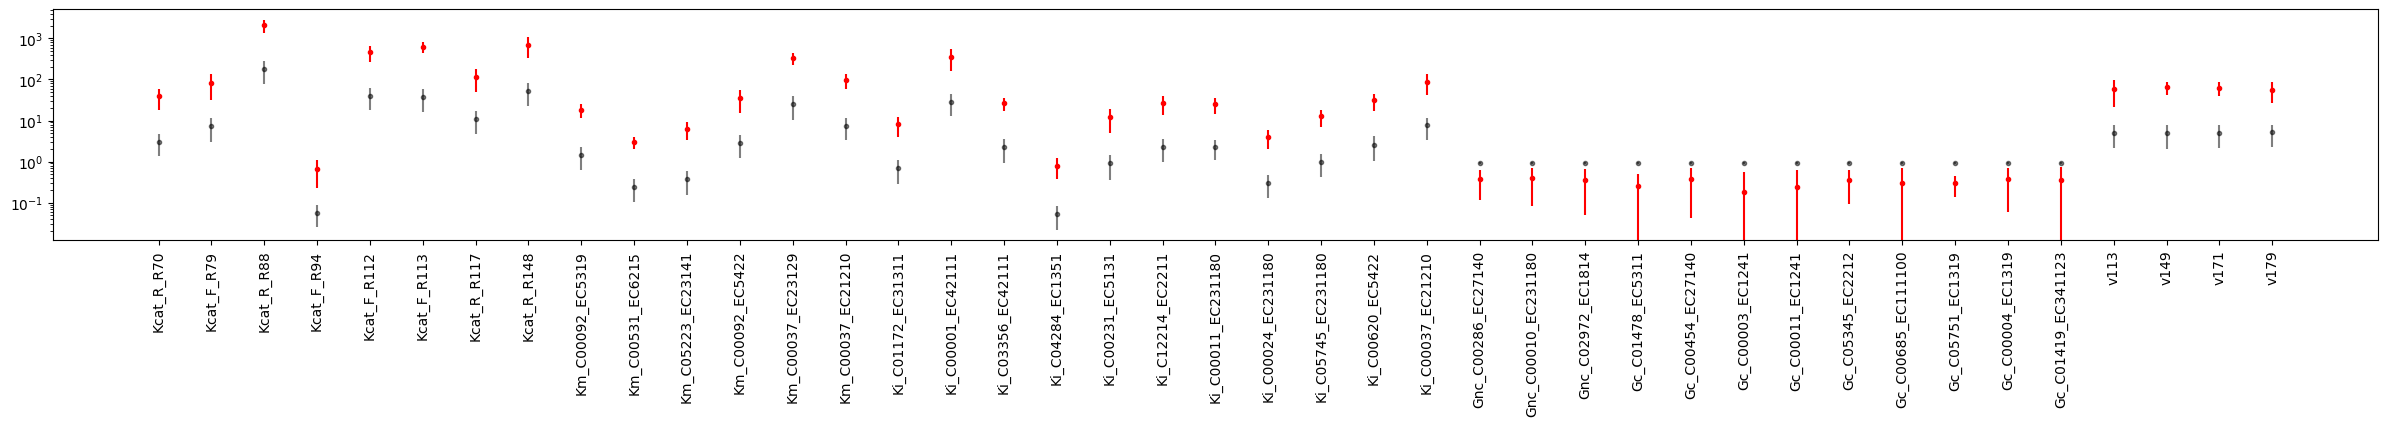

In [155]:
plt.figure(figsize=(30,3))
plt.errorbar(range(sum(index)),myprob._unscale(mean)[index],yerr=(myprob._unscale(mean+std)-myprob._unscale(mean-std))[index], fmt='r.')
plt.errorbar(range(sum(index)),xi.mean(0)[index],yerr=xi.std(0)[index], fmt='k.',alpha = 0.5)
plt.xticks(range(sum(index)),plot_labels[index], rotation = 90);
plt.yscale('log')

In [197]:
top_n = 500
most_ident = np.argsort(std)[:top_n]
least_ident = np.argsort(std)[-top_n:]

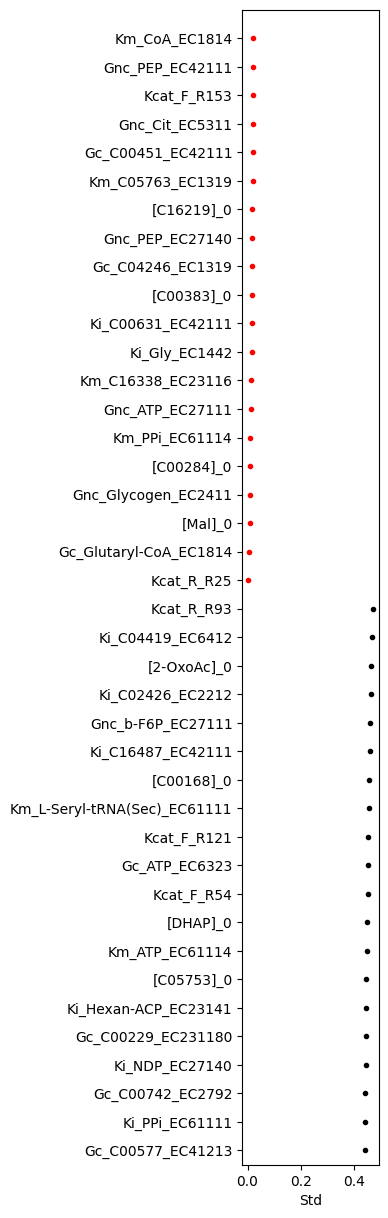

In [179]:
translate_v = {v:m for v,m in zip(metabolites_labels, metabolites)}
v_to_label = lambda x: '['+translate_kegg([translate_v[x]])[0]+"]_0"

plt.figure(figsize=(6,15))
labels = ['Std']
for i,var in enumerate([std]):
    plt.subplot(1,3,i+1)
    order = most_ident
    plt.errorbar(var[order],np.arange(len(least_ident),len(most_ident) + len(least_ident)), fmt='r.')

    order2 = least_ident
    plt.errorbar(var[order2],np.arange(0,len(least_ident)), fmt='k.')

    if i == 0:
        ylabels = list(np.array(parameter_labels)[order2])+list(np.array(parameter_labels)[order])
        for k,l in enumerate(ylabels):
            if 'v' in l:
                ylabels[k] = v_to_label(l)

            elif '_C' in l:
                kg = l.split('_')[1]
                ylabels[k] = l.replace(kg,translate_kegg([kg])[0])

        plt.yticks(np.arange(len(most_ident) + len(least_ident)),ylabels);
    else:
        plt.yticks([])
    plt.ylim([-0.5,len(most_ident) + len(least_ident)])
    plt.xlabel(labels[i])

In [210]:
plot_labels[np.argsort(pcorr/std)[-5:]]

array(['v156', 'Ki_C00229_EC23139', 'Km_C00010_EC1814',
       'Ki_C05753_EC111100', 'v109'], dtype='<U19')

Text(0, 0.5, 'Std. Deviation of Posterior')

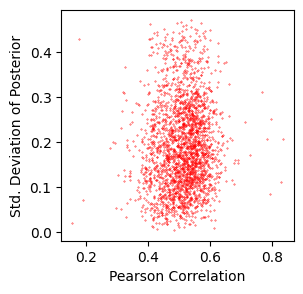

In [61]:
plt.figure(figsize = (3,3))
plt.scatter(pcorr,std,s=0.1,c='r')# alpha = ((pcorr/std)-min(pcorr/std))/(max(pcorr/std)-min(pcorr/std)))
plt.xlabel('Pearson Correlation')
plt.ylabel('Std. Deviation of Posterior')

Text(0, 0.5, 'Std of Posterior')

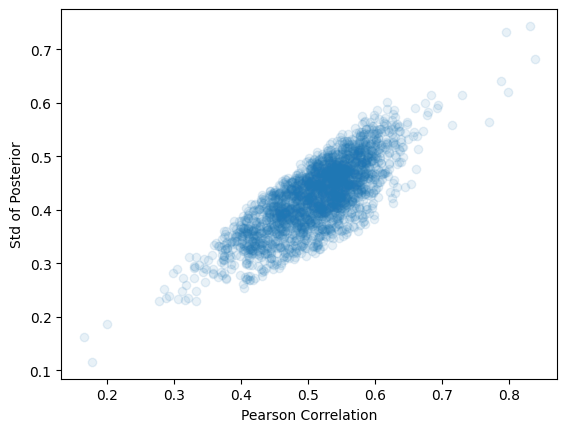

In [338]:
plt.scatter(pcorr,pcorr/np.exp(std), alpha = 0.1)# alpha = ((pcorr/std)-min(pcorr/std))/(max(pcorr/std)-min(pcorr/std)))
plt.xlabel('Pearson Correlation')
plt.ylabel('Std of Posterior')

In [41]:
fs = []
for i in range(600):
    fs.append(myprob.fitness(xis[i,:]))

In [44]:
pcorr = np.abs(r_regression(np.concatenate([pops[0].get_x(),xis]), np.squeeze(np.concatenate([pops[0].get_f(),fs]))))

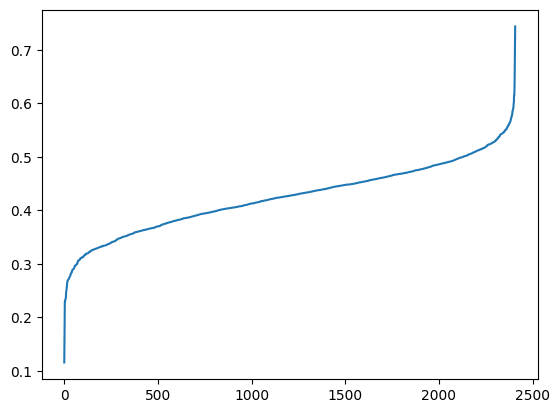

In [354]:
plt.plot(np.sort(pcorr/np.exp(std)))

In [351]:
metabolites = np.array([s for s in r_prefit.getFloatingSpeciesIds() if 'EC' not in s])
enzymes = np.array([s for s in r_prefit.getFloatingSpeciesIds() if 'EC' in s])

m_matrix = []
e_matrix = []

for p in parameter_labels:
    if 'v' in p: 
        p = translate_v[p]

    if 'Kcat' in p:
        p = 'EC'+''.join(model_rxns.loc[model_rxns['Label'] == 'R1']['EC'].values[0].split('.'))
        
    m_matrix.append([m in p for m in metabolites])
    e_matrix.append([e in p for e in enzymes])

m_matrix = np.array(m_matrix)
e_matrix = np.array(e_matrix)

e_score = e_matrix.T@(pcorr/(std))/e_matrix.sum(0)
m_score = m_matrix.T@(pcorr/(std))/m_matrix.sum(0)


In [352]:
translate_kegg(metabolites[np.argsort(m_score)[-10:]])

['C04246',
 'C00451',
 'C16169',
 'C00264',
 'Glutaryl-CoA',
 'Mal',
 'C16470',
 'Glycogen',
 'C00284',
 'C16338']

In [353]:
enzymes[np.argsort(e_score)[-5:]]

array(['EC23116', 'EC4212', 'EC61114', 'EC42111', 'EC2411'], dtype='<U8')

In [350]:
init_concentrations_230623

{'empty': {'C00037': nan,
  'C00149': nan,
  'C00022': nan,
  'C00065': nan,
  'Pyc': nan,
  'Mdh': nan,
  'fdh_Cm': nan,
  'Fdh': nan,
  'biotin': nan,
  'sds': nan,
  'glyA_Ec': nan,
  'fch': nan,
  'ftl': nan,
  'mtdA': nan,
  'Pyc_Aa': nan},
 'mal': {'C00037': nan,
  'C00149': 1.0,
  'C00022': nan,
  'C00065': nan,
  'Pyc': nan,
  'Mdh': nan,
  'fdh_Cm': nan,
  'Fdh': nan,
  'biotin': nan,
  'sds': nan,
  'glyA_Ec': nan,
  'fch': nan,
  'ftl': nan,
  'mtdA': nan,
  'Pyc_Aa': nan},
 'pyr': {'C00037': nan,
  'C00149': nan,
  'C00022': 1.0,
  'C00065': nan,
  'Pyc': nan,
  'Mdh': nan,
  'fdh_Cm': nan,
  'Fdh': nan,
  'biotin': nan,
  'sds': nan,
  'glyA_Ec': nan,
  'fch': nan,
  'ftl': nan,
  'mtdA': nan,
  'Pyc_Aa': nan},
 'ser': {'C00037': nan,
  'C00149': nan,
  'C00022': nan,
  'C00065': 1.0,
  'Pyc': nan,
  'Mdh': nan,
  'fdh_Cm': nan,
  'Fdh': nan,
  'biotin': nan,
  'sds': nan,
  'glyA_Ec': nan,
  'fch': nan,
  'ftl': nan,
  'mtdA': nan,
  'Pyc_Aa': nan},
 'gly': {'C00037': 1.0